In [7]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15
%matplotlib inline
print("Version of pytorch is {}".format(torch.__version__))

Version of pytorch is 2.2.1+cu121


In [8]:
alpha = 0.36
beta = 0.99
delta = 1.0

In [9]:
def k_compute_infty(alpha, beta):
    """ Return the stationary point (or steady state) for full depreciation """
    return (1 / (beta * alpha))**(1/(alpha - 1))

k_infty = k_compute_infty(alpha, beta)
print("Stationary point is {:5f}".format(k_infty))


def Kplus_compute_analytic(K, alpha, beta):
    """ Return the optimal capital stock in the next period  for full depreciation """
    return alpha * beta * K**alpha


def c_compute(K, Knext, alpha, beta):
    """ Return the optimal consumption policy  for full depreciation """
    return Knext**alpha - Knext

Stationary point is 0.199482


In [11]:
num_input = 1
num_hidden1 = 50
num_hidden2 = 50
num_output = 1

class DQN(nn.Module):
  def __init__(self, num_input,num_hidden1,num_hidden2,num_output):
    super(DQN,self).__init__()
    self.layer1 = nn.Linear(num_input,num_hidden1)
    self.layer2 = nn.Linear(num_hidden1,num_hidden2)
    self.layer3 = nn.Linear(num_hidden2, num_output)

  def forward(self,x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return x


model = DQN(num_input,num_hidden1,num_hidden2,num_output)
print(model)


DQN(
  (layer1): Linear(in_features=1, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=1, bias=True)
)


In [12]:
K_test = np.array([[1.], [2.]])
K_test_tensor = torch.tensor(K_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(K_test_tensor)

print("K_test = ", K_test)
print("nn prediction = ", predictions.numpy())

K_test =  [[1.]
 [2.]]
nn prediction =  [[0.42067358]
 [0.39567986]]


In [31]:
def compute_cost_tuple(X, nn):
    """
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state (this is trivial here because the state-space is one dimensional)
    K_t = X

    # compute output today
    Y_t = K_t ** alpha

    # use the neural network to predict the savings rate
    s_t = nn(X)

    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    C_t = Y_t - Y_t * s_t

    # get the state in t + 1
    X_next = K_tplus1

    # get output in the next period
    Y_tplus1 = K_tplus1 ** alpha

    # predict the savings policy in the next period
    s_tplus1 = nn(X_next)

    # predict capital in the next period
    C_tplus1 = Y_tplus1 - s_tplus1 * Y_tplus1

    # compute the return on capital in the next period
    R_tplus1 = alpha * K_tplus1 ** (alpha - 1.)

    # Define the relative Euler error
    errREE = 1 - C_tplus1 / (beta * C_t * (R_tplus1 + 1. - delta))

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = torch.mean(errREE ** 2)

    return cost, errREE, C_t, C_tplus1, K_tplus1, R_tplus1

def compute_cost(X, nn):
    """
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state (this is trivial here because the state-space is one dimensional)
    K_t = X

    # compute output today
    Y_t = K_t ** alpha

    # use the neural network to predict the savings rate
    s_t = nn(X)

    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    C_t = Y_t - Y_t * s_t

    # get the state in t + 1
    X_next = K_tplus1

    # get output in the next period
    Y_tplus1 = K_tplus1 ** alpha

    # predict the savings policy in the next period
    s_tplus1 = nn(X_next)

    # predict capital in the next period
    C_tplus1 = Y_tplus1 - s_tplus1 * Y_tplus1

    # compute the return on capital in the next period
    R_tplus1 = alpha * K_tplus1 ** (alpha - 1.)

    # Define the relative Euler error
    errREE = 1 - C_tplus1 / (beta * C_t * (R_tplus1 + 1. - delta))

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = torch.mean(errREE ** 2)

    return cost



In [32]:
X = torch.tensor([[1.], [2.], [3.]], dtype=torch.float32)
cost, errREE, C_t, C_tplus1, K_tplus1, R_tplus1 = compute_cost_tuple(X, model)
print("Cost:", cost.item())

Cost: 0.008571743033826351


In [33]:
def grad(X, model):
    # Ensure that the model is in training mode
    model.train()



    # Compute the cost and other values
    cost, errREE, C_t, C_tplus1, K_tplus1, R_tplus1 = compute_cost_tuple(X, model)

    # Zero the gradients before running the backward pass
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    cost.backward()

    # Collect the gradients for all the parameters in the neural network
    gradients = [param.grad.clone() for param in model.parameters()]

    return cost.item(), gradients

In [34]:
X = torch.tensor([[1.], [2.], [3.]], dtype=torch.float32)
loss, grads = grad(X, model)

print("Loss:", loss)
print("Gradients:")
for grad in grads:
    print(grad)


Loss: 0.008571743033826351
Gradients:
tensor([[-1.4347e-03],
        [ 0.0000e+00],
        [ 1.7178e-03],
        [-2.3547e-03],
        [ 1.5117e-03],
        [-2.0038e-03],
        [ 0.0000e+00],
        [-3.2446e-04],
        [-4.1024e-03],
        [-2.7785e-03],
        [-8.9480e-04],
        [-1.4879e-03],
        [-1.4701e-03],
        [ 3.3518e-04],
        [-1.8109e-03],
        [ 1.3470e-03],
        [ 3.7539e-03],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 6.4860e-04],
        [-1.8648e-03],
        [ 0.0000e+00],
        [-3.0327e-03],
        [ 1.9260e-03],
        [-5.7497e-03],
        [ 0.0000e+00],
        [ 2.5142e-03],
        [-2.4902e-03],
        [-2.0249e-03],
        [-1.4896e-03],
        [ 7.2177e-04],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 2.7819e-03],
        [ 0.0000e+00],
        [ 3.7748e-03],
        [ 0.0000e+00],
        [-7.4297e-03],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 5.4212e-03],
        [ 3.8244e-0

In [23]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
def get_training_data(k_lb, k_ub, n_data):
    X = torch.rand(n_data, 1) * (k_ub - k_lb) + k_lb
    return X

tensor([[0.7688],
        [0.1363],
        [0.1419],
        [0.4798],
        [0.7559],
        [0.9766],
        [0.5212],
        [0.1146],
        [0.3699],
        [0.7167],
        [0.2009],
        [0.3939],
        [0.4030],
        [0.7689],
        [0.6506],
        [0.6596],
        [0.3883],
        [0.4333],
        [0.8733],
        [0.2652],
        [0.4018],
        [0.3789],
        [0.2278],
        [0.4762],
        [0.1555],
        [0.8013],
        [0.8967],
        [0.1967],
        [0.9033],
        [0.5362],
        [0.9595],
        [0.9372],
        [0.5677],
        [0.4488],
        [0.5488],
        [0.7522],
        [0.2193],
        [0.5008],
        [0.9916],
        [0.7881],
        [0.7200],
        [0.7884],
        [0.2025],
        [0.9070],
        [0.4131],
        [0.1355],
        [0.1121],
        [0.2936],
        [0.6537],
        [0.3967],
        [0.7312],
        [0.3788],
        [0.1970],
        [0.3620],
        [0.2623],
        [0

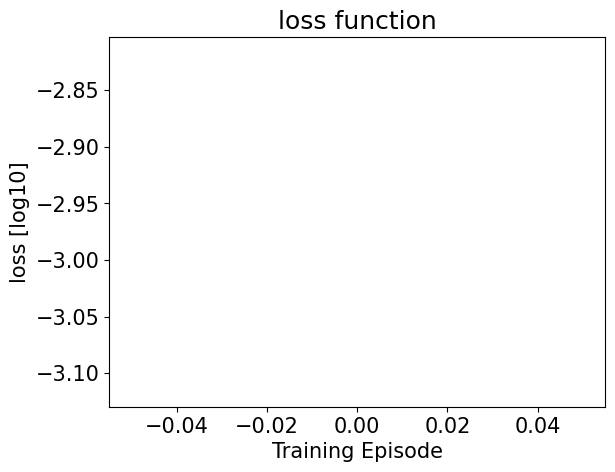

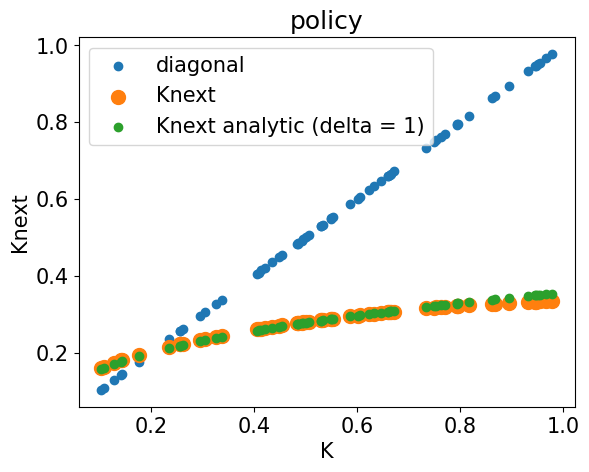

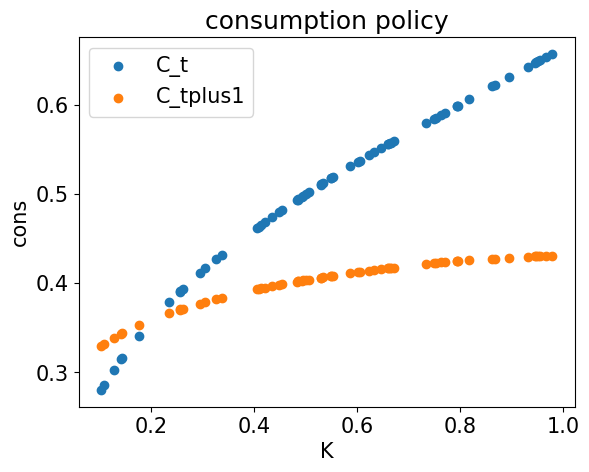

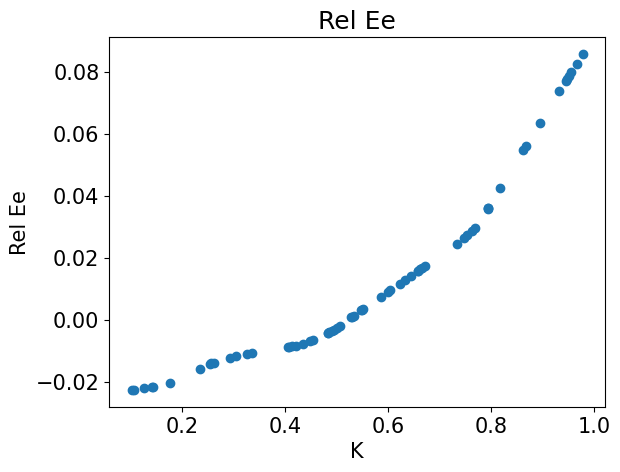

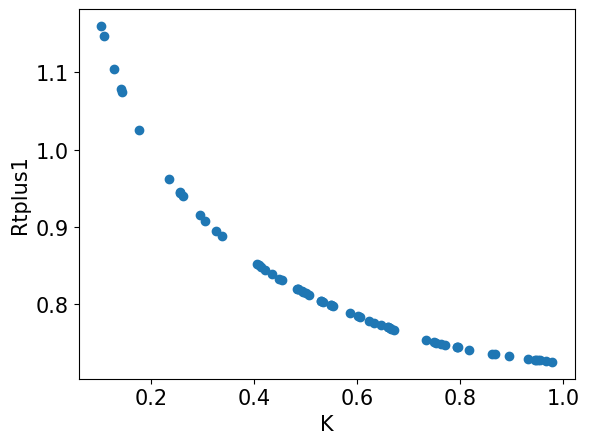

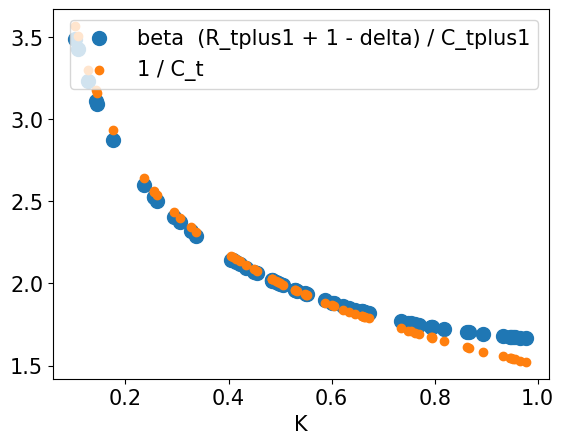

#=================================================================
episode = 100, loss [log10] = -4.977342702362373
#=================================================================
episode = 200, loss [log10] = -5.410425925188318
#=================================================================
episode = 300, loss [log10] = -5.744601074177843
#=================================================================
episode = 400, loss [log10] = -5.936761456611846
#=================================================================
episode = 500, loss [log10] = -6.156333761033842


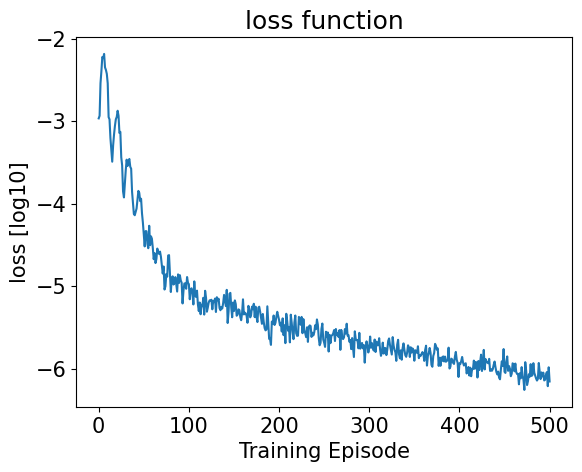

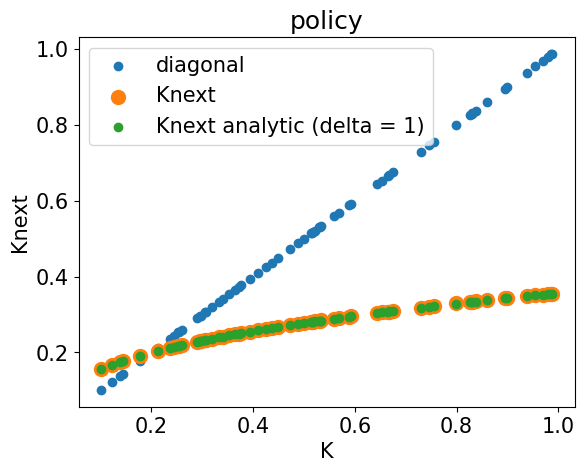

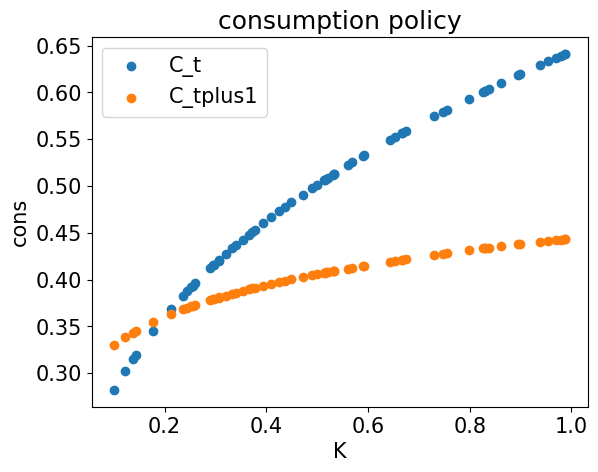

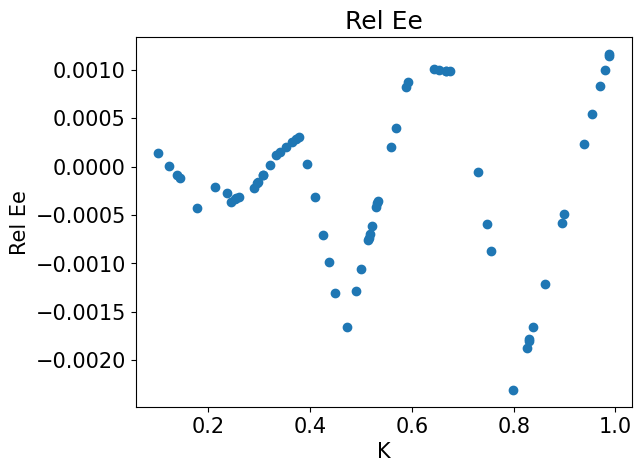

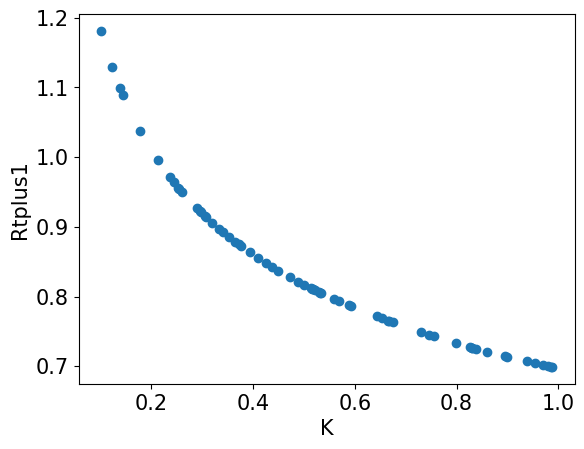

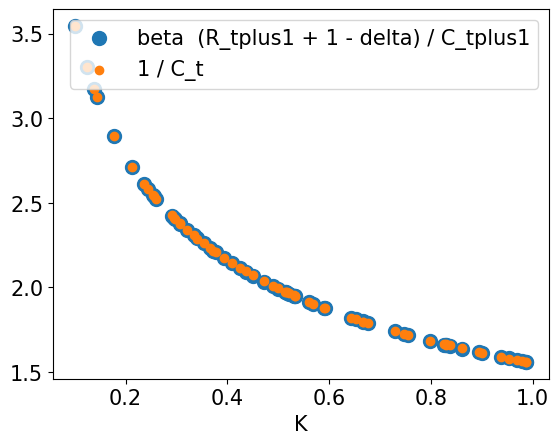

#=================================================================
episode = 600, loss [log10] = -6.3946672036097
#=================================================================
episode = 700, loss [log10] = -6.759603208254645
#=================================================================
episode = 800, loss [log10] = -6.734821783098072
#=================================================================
episode = 900, loss [log10] = -7.031591364259199
#=================================================================
episode = 1000, loss [log10] = -6.941570756666242


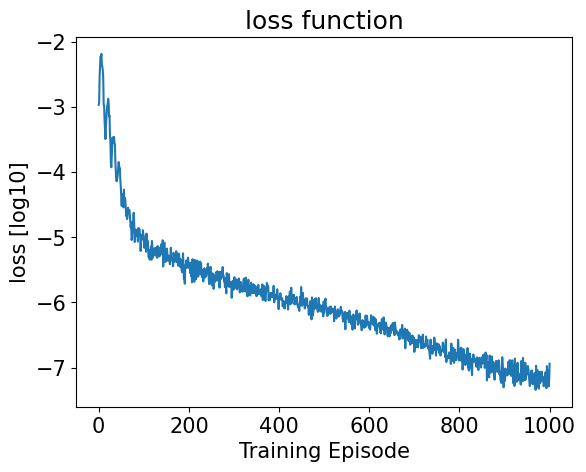

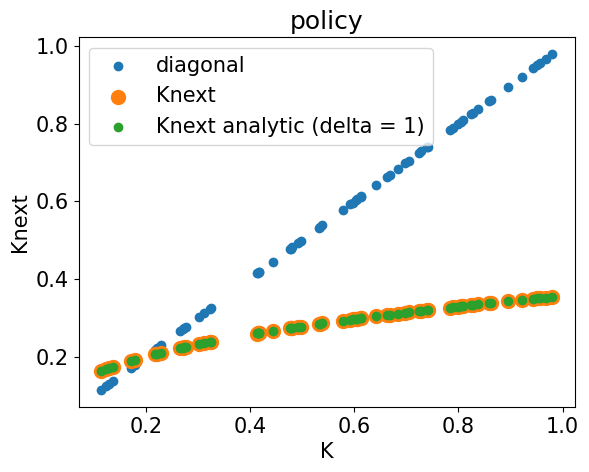

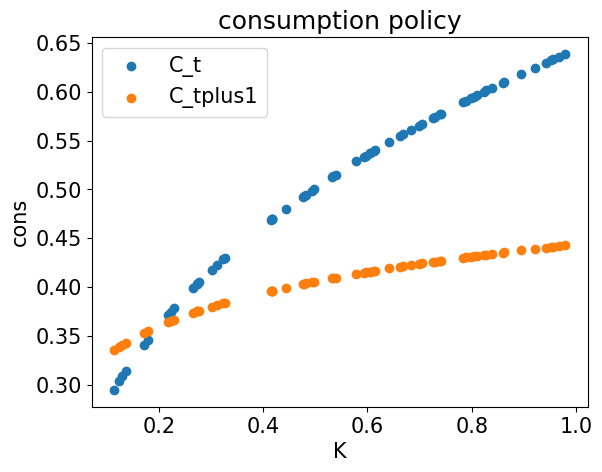

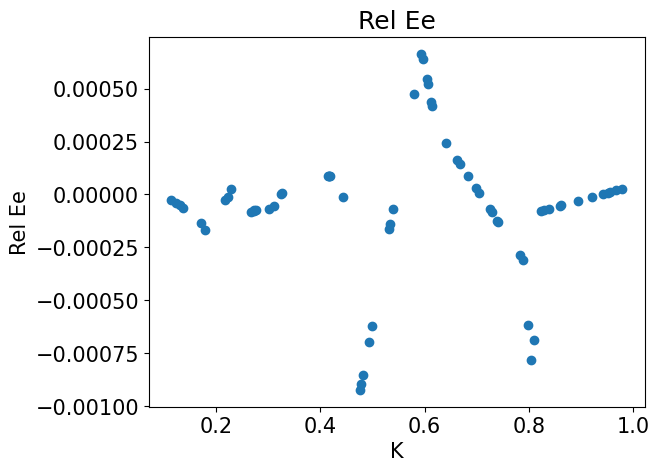

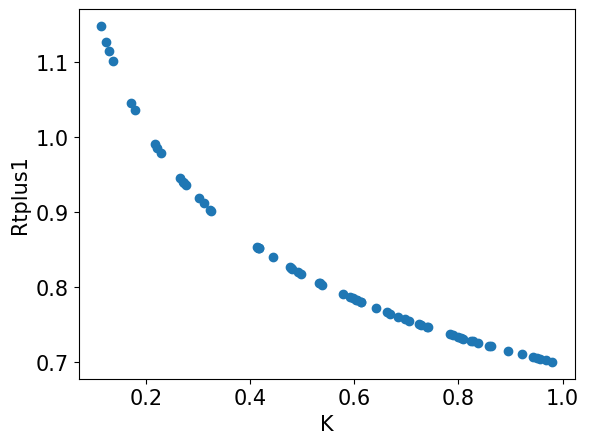

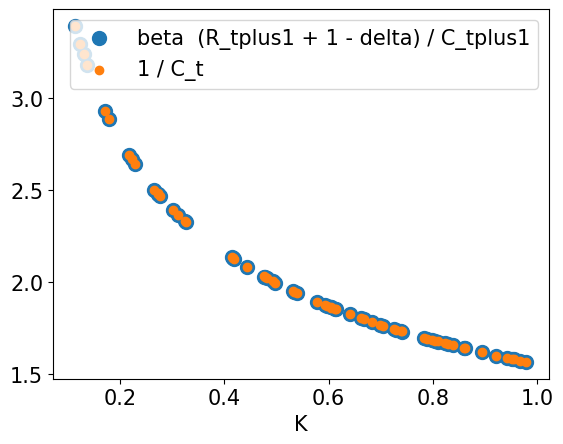

#=================================================================
episode = 1100, loss [log10] = -7.3362540418521585
#=================================================================
episode = 1200, loss [log10] = -7.31149197038901
#=================================================================
episode = 1300, loss [log10] = -7.600361128817781
#=================================================================
episode = 1400, loss [log10] = -7.545210084349683
#=================================================================
episode = 1500, loss [log10] = -7.711353470382676


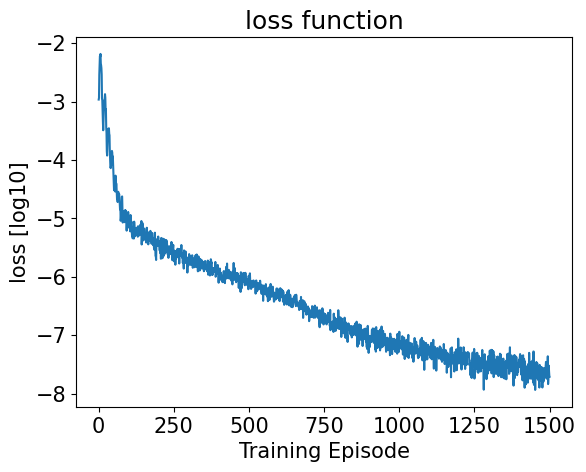

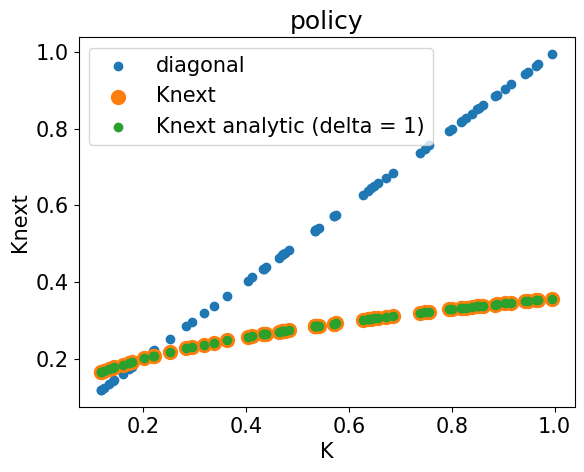

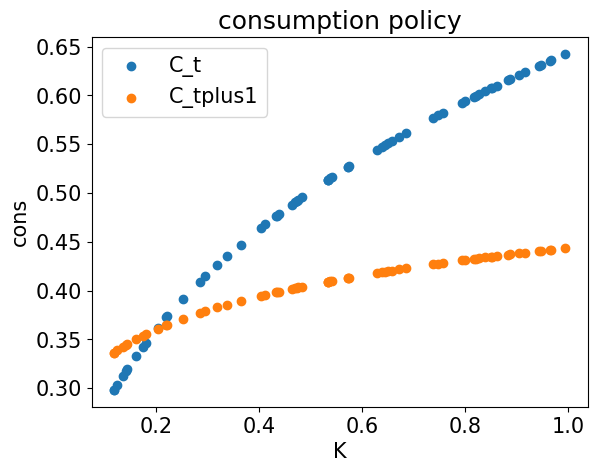

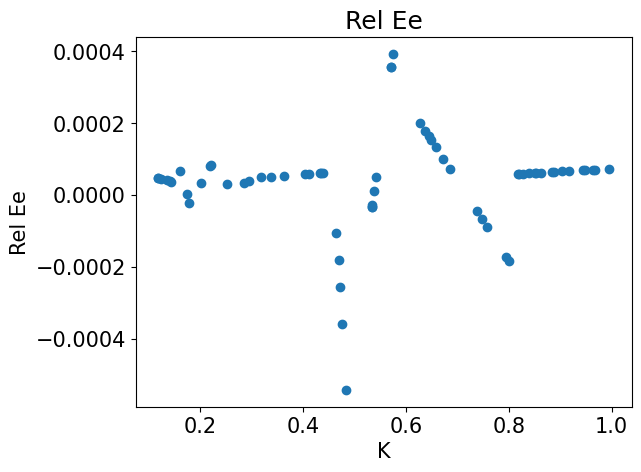

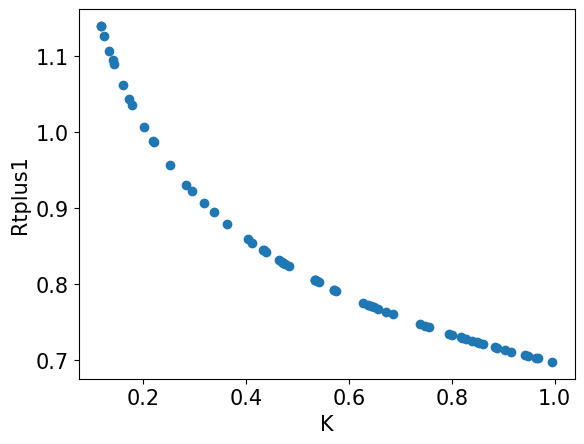

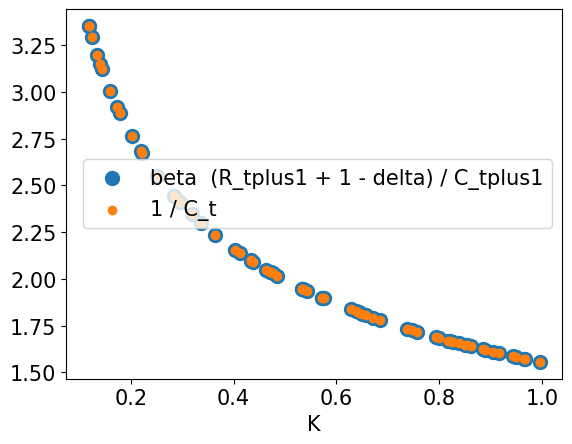

#=================================================================
episode = 1600, loss [log10] = -7.593077246541915
#=================================================================
episode = 1700, loss [log10] = -7.94507027658009
#=================================================================
episode = 1800, loss [log10] = -7.739925863256625
#=================================================================
episode = 1900, loss [log10] = -8.131444425137172
#=================================================================
episode = 2000, loss [log10] = -7.8272380775445525


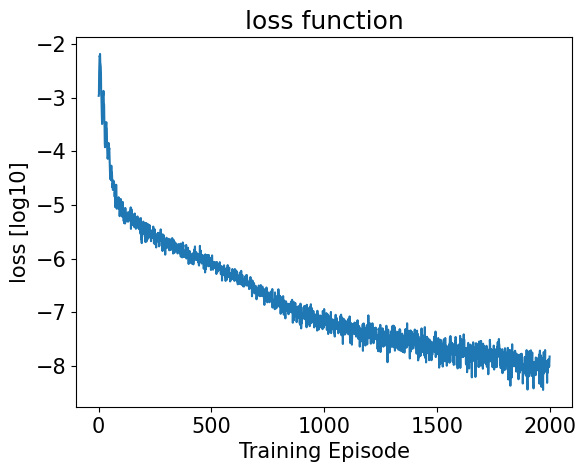

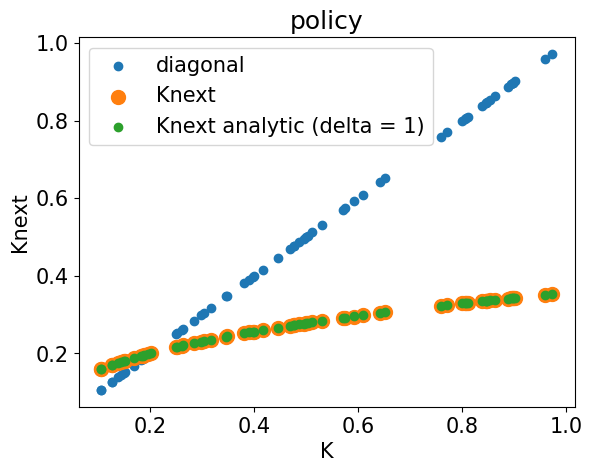

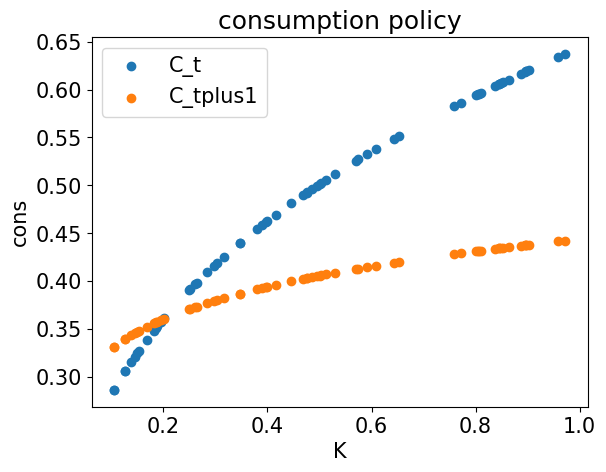

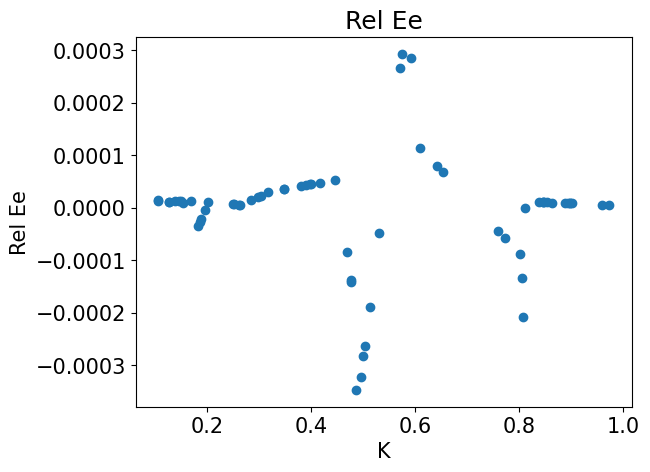

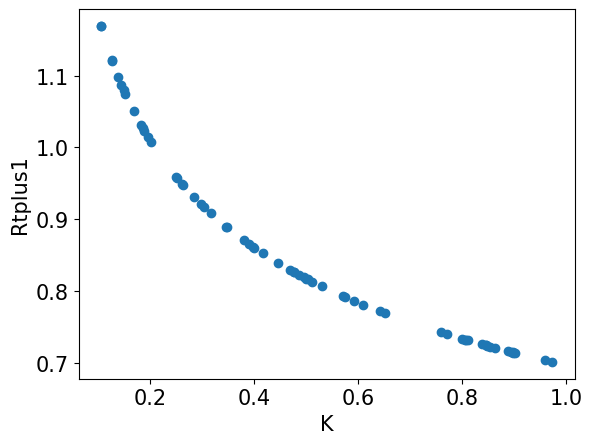

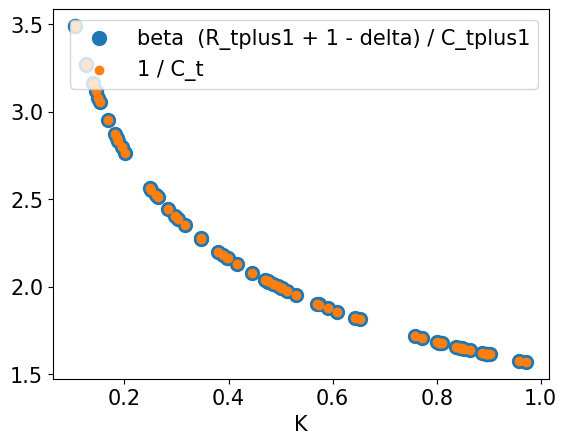

In [41]:
num_episodes = 2001
n_data_per_epi = 64
k_lb = 0.10
k_ub = 1.0
train_loss = []
X = get_training_data(k_lb, k_ub, n_data_per_epi)
print(X)
print(X.shape)
for ep in range(num_episodes):
    # generate training data
    X = get_training_data(k_lb, k_ub, n_data_per_epi)


    loss = compute_cost(X, model)


    optimizer.zero_grad()  # 清除梯度
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数


    # record loss
    train_loss.append(loss.item())

    # print progress
    if ep % 100 == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.item())))

    if ep % 500 == 0:
      cost, errREE, C_t, C_tplus1, K_tplus1, R_tplus1 = compute_cost_tuple(X, model)
      errREE = errREE.detach().numpy()
      C_t = C_t.detach().numpy()
      C_tplus1= C_tplus1.detach().numpy()
      K_tplus1 = K_tplus1.detach().numpy()
      R_tplus1 = R_tplus1.detach().numpy()
      plt.title("loss function")
      plt.plot(np.log10(np.array(train_loss)))
      plt.xlabel("Training Episode")
      plt.ylabel("loss [log10]")
      plt.show()
      plt.close()
      plt.title("policy")
      plt.xlabel("K")
      plt.ylabel("Knext")
      plt.scatter(X[:, 0], X[:, 0], label = "diagonal")
      plt.scatter(X[:, 0], K_tplus1[:, 0], s=100, label = "Knext")
      plt.scatter(X[:, 0], beta * alpha * X[:, 0] ** alpha, label = "Knext analytic (delta = 1)")
      plt.legend()
      plt.show()
      plt.close()
      plt.title("consumption policy")
      plt.xlabel("K")
      plt.ylabel("cons")
      plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
      plt.scatter(X[:, 0], C_tplus1[:, 0], label="C_tplus1")
      plt.legend()
      plt.show()
      plt.close()
      plt.title("Rel Ee")
      plt.xlabel("K")
      plt.ylabel("Rel Ee")
      plt.scatter(X[:, 0], errREE[:, 0], label="REE")
      plt.show()
      plt.close()

      plt.xlabel("K")
      plt.ylabel("Rtplus1")
      plt.scatter(X[:, 0], R_tplus1[:, 0], label="R_tplus1")
      plt.show()
      plt.close()
      plt.xlabel("K")
      plt.scatter(X[:, 0], beta * (R_tplus1[:, 0] + 1. - delta)/C_tplus1[:, 0], s=100, label="beta  (R_tplus1 + 1 - delta) / C_tplus1")
      plt.scatter(X[:, 0], 1/C_t[:, 0], label="1 / C_t")
      plt.legend()
      plt.show()
      plt.close()